The aim is to solve the challenge of predicting whether a photograph is likely to be popular and generate a significant number of downloads. Datasets are accessed from kaggle competition (https://www.kaggle.com/competitions/can-i-be-an-influencer/overview)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/can-i-be-an-influencer/sample_submission.csv
/kaggle/input/can-i-be-an-influencer/test_colors.csv
/kaggle/input/can-i-be-an-influencer/test_keywords.csv
/kaggle/input/can-i-be-an-influencer/train.csv
/kaggle/input/can-i-be-an-influencer/train_colors.csv
/kaggle/input/can-i-be-an-influencer/test.csv
/kaggle/input/can-i-be-an-influencer/train_keywords.csv


In [2]:
# Reading data
train = pd.read_csv('/kaggle/input/can-i-be-an-influencer/train.csv')
train_clr = pd.read_csv('/kaggle/input/can-i-be-an-influencer/train_colors.csv')
train_kw = pd.read_csv('/kaggle/input/can-i-be-an-influencer/train_keywords.csv')
test = pd.read_csv('/kaggle/input/can-i-be-an-influencer/test.csv')
test_clr = pd.read_csv('/kaggle/input/can-i-be-an-influencer/test_colors.csv')
test_kw = pd.read_csv('/kaggle/input/can-i-be-an-influencer/test_keywords.csv')

In [3]:
# Importing Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn import datasets, linear_model
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, SGDRegressor
from sklearn.model_selection import  train_test_split
from sklearn import metrics
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

In [4]:
train.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,iso,aperture_value,focal_length,exposure_time,latitude,longitude,country,city,total_days,stats_downloads
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,...,200.0,14.0,50.0,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,...,100.0,2.5,30.0,1/1250,NaN,NaN,NaN,NaN,1255,1839
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,...,64.0,2.8,48.0,1/1600,NaN,NaN,NaN,NaN,1138,787
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,...,139.0,2.2,4.7,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,...,400.0,6.4,22.2,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982


In [5]:
## Transformations performed to combine information from keyword dataset with the main training dataset
# Take maximum of confidence value in keyword data to retain most relevant keyword record for each image
trainkw_temp = train_kw.groupby('image_id', as_index=False)[['confidence_value']].max()
# trainkw_temp
train_main = pd.merge(train, trainkw_temp, how='inner', on=['image_id'])
# train_main
train_kw_cleaned = pd.merge(train_kw, trainkw_temp, how='inner', on=['image_id', 'confidence_value'])
# train_kw_cleaned
trainkw_occurence = train_kw.groupby(['classification_keyword']).size().reset_index(name='count')

# Sort the dataframe by the column with the number of occurrences of each keyword in descending order
trainkw_occurence = trainkw_occurence.sort_values(by='count', ascending=False).reset_index()

# # Create a new column to hold the rank values
trainkw_occurence['rank'] = trainkw_occurence.index.values
    
# trainkw_occurence
trainkw_ranked = pd.merge(train_kw_cleaned, trainkw_occurence, how='left', on=['classification_keyword']).groupby('image_id', as_index=False).apply(lambda x: x[x['rank'] == x['rank'].min()]).reset_index()
# trainkw_ranked
trainkw_ranked.drop(['index','count','rank','level_0','level_1'], axis=1, inplace=True)
# trainkw_ranked.head()
# original training data with key words data
train_withkw = pd.merge(train, trainkw_ranked, how='left', on=['image_id'])
train_withkw.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,exposure_time,latitude,longitude,country,city,total_days,stats_downloads,image_classification,classification_keyword,confidence_value
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,...,1/60,NaN,NaN,USA,"Wichita, Kansas",2361,167503,Suggested,plant,99.158722
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,...,1/1250,NaN,NaN,NaN,NaN,1255,1839,Predicted,soil,99.999489
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,...,1/1600,NaN,NaN,NaN,NaN,1138,787,Predicted,nature,99.871567
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,...,1/100,32.784562,-79.785303,United States,Isle of Palms,1579,2049,Predicted,water,99.955086
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,...,1/420,66.074878,-23.125068,Island,Ísafjörður,1050,2982,Suggested,nature,99.912849


In [6]:
train_clr['final_score'] = train_clr.apply(lambda row: row['pixel_coverage'] + row['color_score'], axis=1)
# train_clr
trainclr_temp = train_clr.groupby('image_id', as_index=False)[['final_score']].max()
# trainclr_temp
trainclr_full = pd.merge(train_clr, trainclr_temp, how='inner', on=['image_id', 'final_score'])
# trainclr_full
train_full = pd.merge(train_withkw, trainclr_full, how='left', on=['image_id'])
train_full 

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,classification_keyword,confidence_value,R,G,B,image_hex,keyword,pixel_coverage,color_score,final_score
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,...,plant,99.158722,216.0,185.0,199.0,d8b9c7,thistle,0.054467,0.313672,0.368138
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,...,soil,99.999489,250.0,227.0,202.0,FAE3CA,bisque,0.067400,0.468920,0.536320
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,...,nature,99.871567,87.0,85.0,79.0,57554F,dimgray,0.099400,0.260830,0.360230
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,...,water,99.955086,93.0,87.0,79.0,5D574F,dimgray,0.334048,0.433626,0.767673
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,...,nature,99.912849,144.0,122.0,20.0,907A14,olive,0.128400,0.071864,0.200264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12192,18eaca644e,https://unsplash.com/photos/mcUVoqtEzF0,https://images.unsplash.com/photo-156924396944...,2019-09-23 13:07:25.355936,Monday,13,7,25,Featured,4480,...,nature,99.637810,152.0,163.0,91.0,98A35B,darkkhaki,0.027758,0.197931,0.225689
12193,eb25cd769e,https://unsplash.com/photos/DDcD7ZrD4YU,https://images.unsplash.com/photo-1548707519-4...,2019-01-28 20:32:28.827831,Monday,20,32,28,Featured,2403,...,animal,96.121124,118.0,80.0,36.0,765024,saddlebrown,0.122840,0.239778,0.362617
12194,73302461d0,https://unsplash.com/photos/pI2BcDA6Hsw,https://images.unsplash.com/photo-146241318325...,2016-05-05 01:54:16.982329,Thursday,1,54,16,Featured,5184,...,water,77.655396,144.0,193.0,216.0,90c1d8,skyblue,0.170000,0.358981,0.528981
12195,f2587b2b08,https://unsplash.com/photos/nwFNYen-dHY,https://images.unsplash.com/photo-146186648824...,2016-04-28 18:02:32.922228,Thursday,18,2,32,Featured,6000,...,plant,92.314514,228.0,235.0,231.0,e4ebe7,lavender,0.314133,0.112832,0.426965


In [7]:
testkw_temp = test_kw.groupby('image_id', as_index=False)[['confidence_value']].max()
# testkw_temp
test_main = pd.merge(test, testkw_temp, how='inner', on=['image_id'])
# test_main
test_kw_cleaned = pd.merge(test_kw, testkw_temp, how='inner', on=['image_id', 'confidence_value'])
# test_kw_cleaned
testkw_occurence = test_kw.groupby(['classification_keyword']).size().reset_index(name='count')

# Sort the dataframe by the column with the number of occurrences of each keyword in descending order
testkw_occurence = testkw_occurence.sort_values(by='count', ascending=False).reset_index()

# # Create a new column to hold the rank values
testkw_occurence['rank'] = testkw_occurence.index.values
    
# testkw_occurence
testkw_ranked = pd.merge(test_kw_cleaned, testkw_occurence, how='left', on=['classification_keyword']).groupby('image_id', as_index=False).apply(lambda x: x[x['rank'] == x['rank'].min()]).reset_index()
# testkw_ranked
testkw_ranked.drop(['index','count','rank','level_0','level_1'], axis=1, inplace=True)
# testkw_ranked.head()
# original testing data with key words data
test_withkw = pd.merge(test, testkw_ranked, how='left', on=['image_id'])
test_withkw.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,focal_length,exposure_time,latitude,longitude,country,city,total_days,image_classification,classification_keyword,confidence_value
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-157063155096...,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,...,50.0,1/640,NaN,NaN,NaN,NaN,1249,Predicted,plant,99.867035
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-157392442935...,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,...,300.0,1/200,57.273628,-6.215502,Royaume-Uni,NaN,1211,Predicted,animal,98.562889
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3...,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,...,50.0,1/1000,NaN,NaN,NaN,NaN,1439,Predicted,nature,99.946297
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-157538454351...,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,...,85.0,1/200,NaN,NaN,NaN,NaN,1194,Predicted,soil,99.999969
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-3...,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,...,93.0,1/160,NaN,NaN,NaN,NaN,1457,Predicted,plant,99.999527


In [8]:
test_clr['final_score'] = test_clr.apply(lambda row: row['pixel_coverage'] + row['color_score'], axis=1)
# test_clr
testclr_temp = test_clr.groupby('image_id', as_index=False)[['final_score']].max()
# testclr_temp
testclr_full = pd.merge(test_clr, testclr_temp, how='inner', on=['image_id', 'final_score'])
# testclr_full
test_full = pd.merge(test_withkw, testclr_full, how='left', on=['image_id'])
test_full

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,classification_keyword,confidence_value,R,G,B,image_hex,keyword,pixel_coverage,color_score,final_score
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-157063155096...,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,...,plant,99.867035,238.0,231.0,223.0,EEE7DF,antiquewhite,0.853333,0.056898,0.910231
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-157392442935...,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,...,animal,98.562889,56.0,55.0,57.0,383739,darkslategray,0.376067,0.016171,0.392238
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3...,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,...,nature,99.946297,118.0,216.0,200.0,76D8C8,mediumaquamarine,0.128667,0.296128,0.424794
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-157538454351...,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,...,soil,99.999969,51.0,55.0,52.0,333734,darkslategray,0.312000,0.449136,0.761136
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-3...,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,...,plant,99.999527,167.0,157.0,147.0,A79D93,darkgray,0.151800,0.571834,0.723634
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6563,a41cfba199,https://unsplash.com/photos/71KMQp-Qkvw,https://images.unsplash.com/photo-156750559935...,2019-09-03 10:13:49.602738,Tuesday,10,13,49,Featured,3456,...,person,99.274788,196.0,148.0,121.0,C49479,rosybrown,0.017299,0.158563,0.175862
6564,73bbb77964,https://unsplash.com/photos/YiAUAvndoR4,https://images.unsplash.com/photo-156983960209...,2019-09-30 10:33:45.906980,Monday,10,33,45,Featured,4850,...,plant,97.873421,124.0,67.0,26.0,7C431A,saddlebrown,0.049720,0.217389,0.267109
6565,22028b67b0,https://unsplash.com/photos/a7FiLP1hgOc,https://images.unsplash.com/photo-156493586638...,2019-08-04 16:24:57.625060,Sunday,16,24,57,Featured,4480,...,building,98.414749,205.0,143.0,67.0,CD8F43,peru,0.053133,0.103941,0.157074
6566,7abf54e623,https://unsplash.com/photos/5godE_BVywk,https://images.unsplash.com/photo-1555357362-9...,2019-04-15 19:45:53.534674,Monday,19,45,53,Featured,2918,...,clothing,99.986267,232.0,233.0,232.0,E8E9E8,lavender,0.488400,0.051939,0.540339


In [9]:
train.corr()

,obs_hour,obs_min,obs_sec,width,height,aspect_ratio,iso,aperture_value,focal_length,latitude,longitude,total_days,stats_downloads
obs_hour,1.000000,-0.010468,0.006778,-0.015422,-0.014454,-0.002660,-0.019113,0.008707,-0.005258,0.110486,-0.004354,0.017434,-0.004241
obs_min,-0.010468,1.000000,-0.010195,-0.000377,-0.007055,0.005342,-0.016538,-0.005723,-0.012002,-0.034974,0.033722,0.012467,0.006262
obs_sec,0.006778,-0.010195,1.000000,0.009928,0.023508,-0.011045,0.007944,-0.013382,-0.002613,-0.001196,-0.014321,-0.006884,0.008159
width,-0.015422,-0.000377,0.009928,1.000000,0.146659,0.601535,0.038970,0.111747,0.088184,0.012111,-0.057518,0.042229,-0.017073
height,-0.014454,-0.007055,0.023508,0.146659,1.000000,-0.663945,0.027508,-0.057297,-0.004536,0.035806,-0.014804,-0.368445,-0.099657
aspect_ratio,-0.002660,0.005342,-0.011045,0.601535,-0.663945,1.000000,0.007350,0.139267,0.075458,-0.018169,-0.035035,0.358594,0.070788
iso,-0.019113,-0.016538,0.007944,0.038970,0.027508,0.007350,1.000000,-0.034085,0.052211,-0.000185,-0.003327,-0.025526,0.002131
aperture_value,0.008707,-0.005723,-0.013382,0.111747,-0.057297,0.139267,-0.034085,1.000000,0.134524,-0.000043,-0.019795,0.126184,0.048999
focal_length,-0.005258,-0.012002,-0.002613,0.088184,-0.004536,0.075458,0.052211,0.134524,1.000000,-0.041824,-0.014796,-0.052114,-0.010577
latitude,0.110486,-0.034974,-0.001196,0.012111,0.035806,-0.018169,-0.000185,-0.000043,-0.041824,1.000000,-0.388386,0.013743,0.006215


<AxesSubplot:>

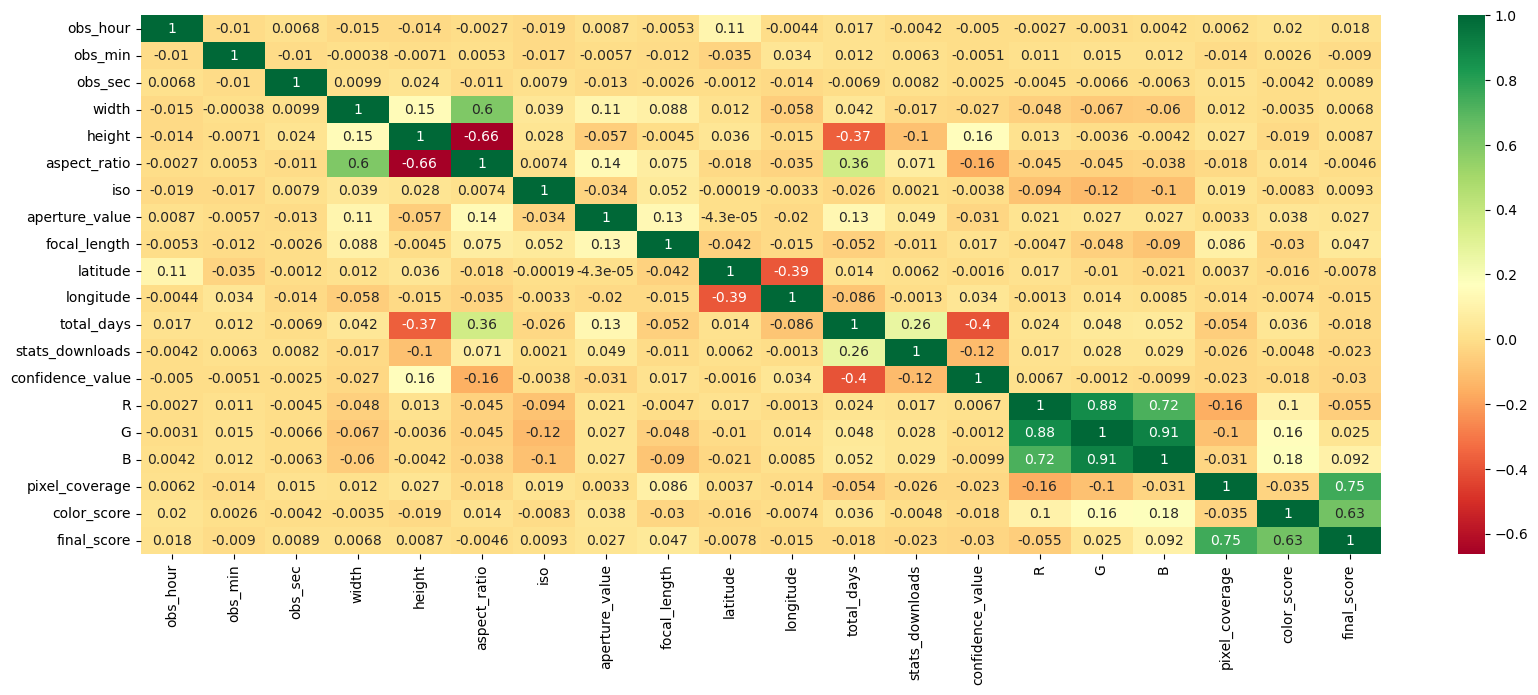

In [10]:
# Correlation Heatmap
plt.figure(figsize=(20,7))
sns.heatmap(train_full.corr(), annot=True, cmap='RdYlGn')

In [11]:
train.columns

Index(['image_id', 'photo_url', 'photo_image_url', 'photo_submitted_at',
       'obs_day', 'obs_hour', 'obs_min', 'obs_sec', 'image_category', 'width',
       'height', 'aspect_ratio', 'description1', 'description2', 'camera_make',
       'camera_model', 'iso', 'aperture_value', 'focal_length',
       'exposure_time', 'latitude', 'longitude', 'country', 'city',
       'total_days', 'stats_downloads'],
      dtype='object')

In [12]:
train_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12197 entries, 0 to 12196
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   image_id                12197 non-null  object 
 1   photo_url               12197 non-null  object 
 2   photo_image_url         12197 non-null  object 
 3   photo_submitted_at      12197 non-null  object 
 4   obs_day                 12197 non-null  object 
 5   obs_hour                12197 non-null  int64  
 6   obs_min                 12197 non-null  int64  
 7   obs_sec                 12197 non-null  int64  
 8   image_category          12197 non-null  object 
 9   width                   12197 non-null  int64  
 10  height                  12197 non-null  int64  
 11  aspect_ratio            12197 non-null  float64
 12  description1            5151 non-null   object 
 13  description2            11544 non-null  object 
 14  camera_make             12157 non-null

In [13]:
# Check for missing data
total = train_full.isnull().sum().sort_values(ascending=False)
percent = (train_full.isnull().sum()/train_full.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
city,9147,0.749939
longitude,8725,0.715340
latitude,8723,0.715176
country,7908,0.648356
description1,7046,0.577683
description2,653,0.053538
iso,55,0.004509
exposure_time,48,0.003935
camera_model,48,0.003935
camera_make,40,0.003279


In [14]:
train_full.shape

(12197, 37)

In [15]:
n = train_full.nunique(axis=0)
  
print("No.of.unique values in each column :\n",
      n)

No.of.unique values in each column :
 image_id                  12197
photo_url                 12197
photo_image_url           12197
photo_submitted_at        12187
obs_day                       7
obs_hour                     24
obs_min                      60
obs_sec                      60
image_category                2
width                      2792
height                     2894
aspect_ratio                171
description1               4911
description2               9886
camera_make                  80
camera_model                650
iso                         129
aperture_value               83
focal_length                492
exposure_time               442
latitude                   2635
longitude                  2667
country                     299
city                       1893
total_days                 1778
stats_downloads            7260
image_classification          2
classification_keyword      183
confidence_value          11620
R                           256
G 

In [16]:
train_full.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,classification_keyword,confidence_value,R,G,B,image_hex,keyword,pixel_coverage,color_score,final_score
0,68105c019b,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,...,plant,99.158722,216.0,185.0,199.0,d8b9c7,thistle,0.054467,0.313672,0.368138
1,06d11c4edd,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,...,soil,99.999489,250.0,227.0,202.0,FAE3CA,bisque,0.067400,0.468920,0.536320
2,f6599edba1,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,...,nature,99.871567,87.0,85.0,79.0,57554F,dimgray,0.099400,0.260830,0.360230
3,0f4bcc2d36,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,...,water,99.955086,93.0,87.0,79.0,5D574F,dimgray,0.334048,0.433626,0.767673
4,74db502ed5,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,...,nature,99.912849,144.0,122.0,20.0,907A14,olive,0.128400,0.071864,0.200264


In [17]:
# Label encoding the categorical features
from sklearn.preprocessing import LabelEncoder
scaler = LabelEncoder()
df = train_full.copy()
df['image_id'] = scaler.fit_transform(df['image_id'])
df['image_classification'] = scaler.fit_transform(df['image_classification'])
df['classification_keyword'] = scaler.fit_transform(df['classification_keyword'])
df['image_hex'] = scaler.fit_transform(df['image_hex'])
df['keyword'] = scaler.fit_transform(df['keyword'])

In [18]:
# Drop the columns with high amount of missing data as the features would make the model bias
df.drop(['city',
'longitude',
'latitude',
'country',
'description1',
'description2'], axis=1, inplace=True)

df.head()


,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,classification_keyword,confidence_value,R,G,B,image_hex,keyword,pixel_coverage,color_score,final_score
0,5047,https://unsplash.com/photos/7AcMUSYRZpU,https://images.unsplash.com/photo-147455715737...,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,...,115,99.158722,216.0,185.0,199.0,11207,117,0.054467,0.313672,0.368138
1,328,https://unsplash.com/photos/grWwLCSRr4o,https://images.unsplash.com/photo-157005349769...,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,...,142,99.999489,250.0,227.0,202.0,10437,5,0.067400,0.468920,0.536320
2,11708,https://unsplash.com/photos/OR4q9_Y2nuY,https://images.unsplash.com/photo-158018448188...,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,...,104,99.871567,87.0,85.0,79.0,4542,35,0.099400,0.260830,0.360230
3,725,https://unsplash.com/photos/Qc3AmsZ3g2A,https://images.unsplash.com/photo-1542066365-0...,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,...,172,99.955086,93.0,87.0,79.0,4750,35,0.334048,0.433626,0.767673
4,5614,https://unsplash.com/photos/6BLE9HVwIJw,https://images.unsplash.com/photo-158781208024...,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,...,104,99.912849,144.0,122.0,20.0,6461,82,0.128400,0.071864,0.200264


In [19]:
# Drop the columns with high amount of missing data as the features would make the model bias
test_full.drop(['city',
'longitude',
'latitude',
'country',
'description1',
'description2'], axis=1, inplace=True)

test_full.head()

,image_id,photo_url,photo_image_url,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,...,classification_keyword,confidence_value,R,G,B,image_hex,keyword,pixel_coverage,color_score,final_score
0,2322208d63,https://unsplash.com/photos/FuX1NIv8lLk,https://images.unsplash.com/photo-157063155096...,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,...,plant,99.867035,238.0,231.0,223.0,EEE7DF,antiquewhite,0.853333,0.056898,0.910231
1,847b5fcee1,https://unsplash.com/photos/t5rBtxLiHj8,https://images.unsplash.com/photo-157392442935...,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,...,animal,98.562889,56.0,55.0,57.0,383739,darkslategray,0.376067,0.016171,0.392238
2,0e1a37b065,https://unsplash.com/photos/9jdlJzl6yN8,https://images.unsplash.com/photo-1554188068-3...,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,...,nature,99.946297,118.0,216.0,200.0,76D8C8,mediumaquamarine,0.128667,0.296128,0.424794
3,8c8c9d4355,https://unsplash.com/photos/qAbR6rwlCrg,https://images.unsplash.com/photo-157538454351...,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,...,soil,99.999969,51.0,55.0,52.0,333734,darkslategray,0.312000,0.449136,0.761136
4,8ff19c3747,https://unsplash.com/photos/-S6R1ePsKEc,https://images.unsplash.com/photo-1552613545-3...,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,...,plant,99.999527,167.0,157.0,147.0,A79D93,darkgray,0.151800,0.571834,0.723634


In [20]:
df.drop(['photo_url', 'photo_image_url'], axis=1, inplace=True)
df.head()

,image_id,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,...,classification_keyword,confidence_value,R,G,B,image_hex,keyword,pixel_coverage,color_score,final_score
0,5047,2016-09-22 15:13:10.134081,Thursday,15,13,10,Featured,2592,1728,1.50,...,115,99.158722,216.0,185.0,199.0,11207,117,0.054467,0.313672,0.368138
1,328,2019-10-02 21:59:51.712464,Wednesday,21,59,51,Featured,4000,6000,0.67,...,142,99.999489,250.0,227.0,202.0,10437,5,0.067400,0.468920,0.536320
2,11708,2020-01-28 04:10:11.128061,Tuesday,4,10,11,Featured,5504,8256,0.67,...,104,99.871567,87.0,85.0,79.0,4542,35,0.099400,0.260830,0.360230
3,725,2018-11-12 23:46:21.990378,Monday,23,46,21,Featured,3627,2040,1.78,...,172,99.955086,93.0,87.0,79.0,4750,35,0.334048,0.433626,0.767673
4,5614,2020-04-25 11:04:20.912527,Saturday,11,4,20,Featured,4896,3264,1.50,...,104,99.912849,144.0,122.0,20.0,6461,82,0.128400,0.071864,0.200264


In [21]:
test_full.drop(['photo_url', 'photo_image_url'], axis=1, inplace=True)
test_full.head()

,image_id,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,...,classification_keyword,confidence_value,R,G,B,image_hex,keyword,pixel_coverage,color_score,final_score
0,2322208d63,2019-10-09 14:32:57.822408,Wednesday,14,32,57,Featured,4016,6016,0.67,...,plant,99.867035,238.0,231.0,223.0,EEE7DF,antiquewhite,0.853333,0.056898,0.910231
1,847b5fcee1,2019-11-16 17:15:26.021693,Saturday,17,15,26,Featured,6240,4160,1.50,...,animal,98.562889,56.0,55.0,57.0,383739,darkslategray,0.376067,0.016171,0.392238
2,0e1a37b065,2019-04-02 06:54:42.103328,Tuesday,6,54,42,Featured,5472,3648,1.50,...,nature,99.946297,118.0,216.0,200.0,76D8C8,mediumaquamarine,0.128667,0.296128,0.424794
3,8c8c9d4355,2019-12-03 14:49:46.298627,Tuesday,14,49,46,Featured,4000,6000,0.67,...,soil,99.999969,51.0,55.0,52.0,333734,darkslategray,0.312000,0.449136,0.761136
4,8ff19c3747,2019-03-15 01:32:29.162786,Friday,1,32,29,Featured,6000,4000,1.50,...,plant,99.999527,167.0,157.0,147.0,A79D93,darkgray,0.151800,0.571834,0.723634


In [22]:
df['obs_day'] = scaler.fit_transform(df['obs_day'])
df['image_category'] = scaler.fit_transform(df['image_category'])
df['camera_make'] = scaler.fit_transform(df['camera_make'])
df['camera_model'] = scaler.fit_transform(df['camera_model'])
test_full['image_category'] = scaler.fit_transform(test_full['image_category'])

df.head()

,image_id,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,...,classification_keyword,confidence_value,R,G,B,image_hex,keyword,pixel_coverage,color_score,final_score
0,5047,2016-09-22 15:13:10.134081,4,15,13,10,0,2592,1728,1.50,...,115,99.158722,216.0,185.0,199.0,11207,117,0.054467,0.313672,0.368138
1,328,2019-10-02 21:59:51.712464,6,21,59,51,0,4000,6000,0.67,...,142,99.999489,250.0,227.0,202.0,10437,5,0.067400,0.468920,0.536320
2,11708,2020-01-28 04:10:11.128061,5,4,10,11,0,5504,8256,0.67,...,104,99.871567,87.0,85.0,79.0,4542,35,0.099400,0.260830,0.360230
3,725,2018-11-12 23:46:21.990378,1,23,46,21,0,3627,2040,1.78,...,172,99.955086,93.0,87.0,79.0,4750,35,0.334048,0.433626,0.767673
4,5614,2020-04-25 11:04:20.912527,2,11,4,20,0,4896,3264,1.50,...,104,99.912849,144.0,122.0,20.0,6461,82,0.128400,0.071864,0.200264


In [23]:
df.dtypes

image_id                    int64
photo_submitted_at         object
obs_day                     int64
obs_hour                    int64
obs_min                     int64
obs_sec                     int64
image_category              int64
width                       int64
height                      int64
aspect_ratio              float64
camera_make                 int64
camera_model                int64
iso                       float64
aperture_value            float64
focal_length              float64
exposure_time              object
total_days                  int64
stats_downloads             int64
image_classification        int64
classification_keyword      int64
confidence_value          float64
R                         float64
G                         float64
B                         float64
image_hex                   int64
keyword                     int64
pixel_coverage            float64
color_score               float64
final_score               float64
dtype: object

In [24]:
# category = df['exposure_time'].unique()
# category

In [25]:
df['exposure_time'] = scaler.fit_transform(df['exposure_time'])
df

,image_id,photo_submitted_at,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,...,classification_keyword,confidence_value,R,G,B,image_hex,keyword,pixel_coverage,color_score,final_score
0,5047,2016-09-22 15:13:10.134081,4,15,13,10,0,2592,1728,1.50,...,115,99.158722,216.0,185.0,199.0,11207,117,0.054467,0.313672,0.368138
1,328,2019-10-02 21:59:51.712464,6,21,59,51,0,4000,6000,0.67,...,142,99.999489,250.0,227.0,202.0,10437,5,0.067400,0.468920,0.536320
2,11708,2020-01-28 04:10:11.128061,5,4,10,11,0,5504,8256,0.67,...,104,99.871567,87.0,85.0,79.0,4542,35,0.099400,0.260830,0.360230
3,725,2018-11-12 23:46:21.990378,1,23,46,21,0,3627,2040,1.78,...,172,99.955086,93.0,87.0,79.0,4750,35,0.334048,0.433626,0.767673
4,5614,2020-04-25 11:04:20.912527,2,11,4,20,0,4896,3264,1.50,...,104,99.912849,144.0,122.0,20.0,6461,82,0.128400,0.071864,0.200264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12192,1185,2019-09-23 13:07:25.355936,1,13,7,25,0,4480,6111,0.73,...,104,99.637810,152.0,163.0,91.0,6732,22,0.027758,0.197931,0.225689
12193,11176,2019-01-28 20:32:28.827831,1,20,32,28,0,2403,3337,0.72,...,6,96.121124,118.0,80.0,36.0,5607,102,0.122840,0.239778,0.362617
12194,5545,2016-05-05 01:54:16.982329,4,1,54,16,0,5184,3456,1.50,...,172,77.655396,144.0,193.0,216.0,6473,109,0.170000,0.358981,0.528981
12195,11541,2016-04-28 18:02:32.922228,4,18,2,32,0,6000,4000,1.50,...,115,92.314514,228.0,235.0,231.0,11368,52,0.314133,0.112832,0.426965


In [26]:
df.dtypes

image_id                    int64
photo_submitted_at         object
obs_day                     int64
obs_hour                    int64
obs_min                     int64
obs_sec                     int64
image_category              int64
width                       int64
height                      int64
aspect_ratio              float64
camera_make                 int64
camera_model                int64
iso                       float64
aperture_value            float64
focal_length              float64
exposure_time               int64
total_days                  int64
stats_downloads             int64
image_classification        int64
classification_keyword      int64
confidence_value          float64
R                         float64
G                         float64
B                         float64
image_hex                   int64
keyword                     int64
pixel_coverage            float64
color_score               float64
final_score               float64
dtype: object

<AxesSubplot:>

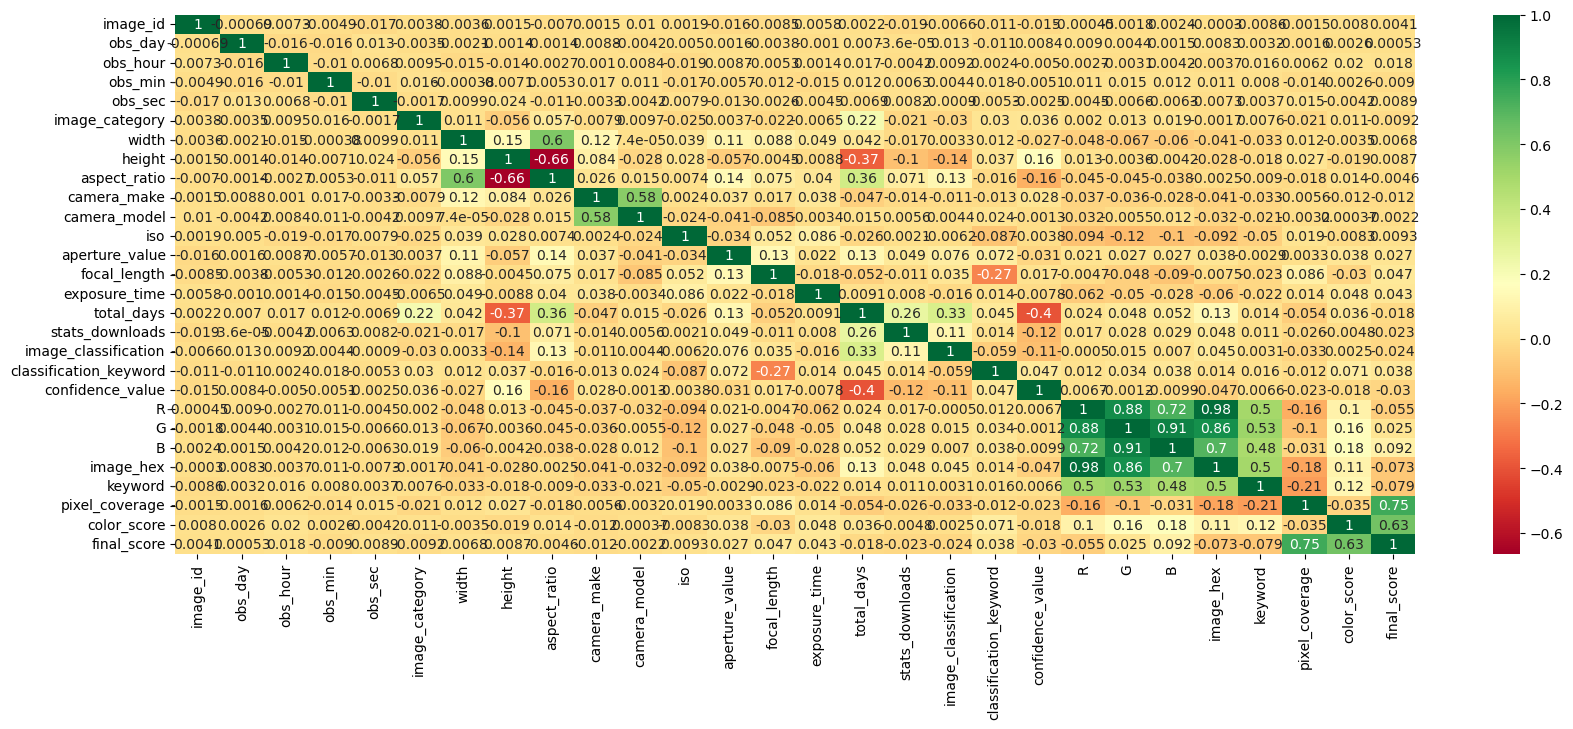

In [27]:
# Correlation Heatmap
plt.figure(figsize=(20,7))
sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

In [28]:
# Impute data where missing mean or mode
df['iso'] = df['iso'].fillna(value=df.iso.mean())
df['exposure_time'] = df['exposure_time'].fillna(value=df.exposure_time.mode()[0])
df['camera_model'] = df['camera_model'].fillna(value=df.camera_model.mode()[0])
df['camera_make'] = df['camera_make'].fillna(value=df.camera_make.mode()[0])
df['aperture_value'] = df['aperture_value'].fillna(value=df.aperture_value.mean())
df['image_hex'] = df['image_hex'].fillna(value=df.image_hex.mode()[0])
df['keyword'] = df['keyword'].fillna(value=df.keyword.mode()[0])
df['pixel_coverage'] = df['pixel_coverage'].fillna(value=df.pixel_coverage.mean())
df['color_score'] = df['color_score'].fillna(value=df.color_score.mean())
df['final_score'] = df['final_score'].fillna(value=df.final_score.mean())

In [29]:
# Impute data where missing mean or mode
test_full['iso'] = test_full['iso'].fillna(value=test_full.iso.mean())
test_full['exposure_time'] = test_full['exposure_time'].fillna(value=test_full.exposure_time.mode()[0])
test_full['camera_model'] = test_full['camera_model'].fillna(value=test_full.camera_model.mode()[0])
test_full['camera_make'] = test_full['camera_make'].fillna(value=test_full.camera_make.mode()[0])
test_full['aperture_value'] = test_full['aperture_value'].fillna(value=test_full.aperture_value.mean())
test_full['image_hex'] = test_full['image_hex'].fillna(value=test_full.image_hex.mode()[0])
test_full['keyword'] = test_full['keyword'].fillna(value=test_full.keyword.mode()[0])
test_full['pixel_coverage'] = test_full['pixel_coverage'].fillna(value=test_full.pixel_coverage.mean())
test_full['color_score'] = test_full['color_score'].fillna(value=test_full.color_score.mean())
test_full['final_score'] = test_full['final_score'].fillna(value=test_full.final_score.mean())

In [30]:
df = df.drop(['photo_submitted_at'], axis = 1)

In [31]:
df = df.drop(['R','G','B'], axis = 1)

In [32]:
test_full = test_full.drop(['R','G','B'], axis = 1)

In [33]:
df.head()

,image_id,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,...,total_days,stats_downloads,image_classification,classification_keyword,confidence_value,image_hex,keyword,pixel_coverage,color_score,final_score
0,5047,4,15,13,10,0,2592,1728,1.50,5,...,2361,167503,1,115,99.158722,11207,117,0.054467,0.313672,0.368138
1,328,6,21,59,51,0,4000,6000,0.67,59,...,1255,1839,0,142,99.999489,10437,5,0.067400,0.468920,0.536320
2,11708,5,4,10,11,0,5504,8256,0.67,42,...,1138,787,0,104,99.871567,4542,35,0.099400,0.260830,0.360230
3,725,1,23,46,21,0,3627,2040,1.78,12,...,1579,2049,0,172,99.955086,4750,35,0.334048,0.433626,0.767673
4,5614,2,11,4,20,0,4896,3264,1.50,18,...,1050,2982,1,104,99.912849,6461,82,0.128400,0.071864,0.200264


In [34]:
df.isnull().sum()

image_id                  0
obs_day                   0
obs_hour                  0
obs_min                   0
obs_sec                   0
image_category            0
width                     0
height                    0
aspect_ratio              0
camera_make               0
camera_model              0
iso                       0
aperture_value            0
focal_length              0
exposure_time             0
total_days                0
stats_downloads           0
image_classification      0
classification_keyword    0
confidence_value          0
image_hex                 0
keyword                   0
pixel_coverage            0
color_score               0
final_score               0
dtype: int64

In [35]:
test_full.isnull().sum()

image_id                  0
photo_submitted_at        0
obs_day                   0
obs_hour                  0
obs_min                   0
obs_sec                   0
image_category            0
width                     0
height                    0
aspect_ratio              0
camera_make               0
camera_model              0
iso                       0
aperture_value            0
focal_length              0
exposure_time             0
total_days                0
image_classification      0
classification_keyword    0
confidence_value          0
image_hex                 0
keyword                   0
pixel_coverage            0
color_score               0
final_score               0
dtype: int64

In [36]:
df.shape, train.shape

((12197, 25), (12197, 26))

In [37]:
df.head()

,image_id,obs_day,obs_hour,obs_min,obs_sec,image_category,width,height,aspect_ratio,camera_make,...,total_days,stats_downloads,image_classification,classification_keyword,confidence_value,image_hex,keyword,pixel_coverage,color_score,final_score
0,5047,4,15,13,10,0,2592,1728,1.50,5,...,2361,167503,1,115,99.158722,11207,117,0.054467,0.313672,0.368138
1,328,6,21,59,51,0,4000,6000,0.67,59,...,1255,1839,0,142,99.999489,10437,5,0.067400,0.468920,0.536320
2,11708,5,4,10,11,0,5504,8256,0.67,42,...,1138,787,0,104,99.871567,4542,35,0.099400,0.260830,0.360230
3,725,1,23,46,21,0,3627,2040,1.78,12,...,1579,2049,0,172,99.955086,4750,35,0.334048,0.433626,0.767673
4,5614,2,11,4,20,0,4896,3264,1.50,18,...,1050,2982,1,104,99.912849,6461,82,0.128400,0.071864,0.200264


In [38]:
X = df[[
       'image_id','image_category', 'width', 'height', 'aspect_ratio', 
    'total_days','image_classification','classification_keyword',
    'confidence_value','keyword','pixel_coverage','color_score']]
X.head()

,image_id,image_category,width,height,aspect_ratio,total_days,image_classification,classification_keyword,confidence_value,keyword,pixel_coverage,color_score
0,5047,0,2592,1728,1.50,2361,1,115,99.158722,117,0.054467,0.313672
1,328,0,4000,6000,0.67,1255,0,142,99.999489,5,0.067400,0.468920
2,11708,0,5504,8256,0.67,1138,0,104,99.871567,35,0.099400,0.260830
3,725,0,3627,2040,1.78,1579,0,172,99.955086,35,0.334048,0.433626
4,5614,0,4896,3264,1.50,1050,1,104,99.912849,82,0.128400,0.071864


In [39]:
testX = test_full.copy()
testX = testX[[
       'image_id','image_category', 'width', 'height', 'aspect_ratio', 
    'total_days','image_classification','classification_keyword',
    'confidence_value','keyword','pixel_coverage','color_score']]
testX['image_id'] = scaler.fit_transform(testX['image_id'])
testX['image_classification'] = scaler.fit_transform(testX['image_classification'])
testX['classification_keyword'] = scaler.fit_transform(testX['classification_keyword'])
testX['keyword'] = scaler.fit_transform(testX['keyword'])

testX.head()

,image_id,image_category,width,height,aspect_ratio,total_days,image_classification,classification_keyword,confidence_value,keyword,pixel_coverage,color_score
0,903,0,4016,6016,0.67,1249,0,80,99.867035,1,0.853333,0.056898
1,3396,0,6240,4160,1.50,1211,0,2,98.562889,28,0.376067,0.016171
2,358,0,5472,3648,1.50,1439,0,70,99.946297,61,0.128667,0.296128
3,3598,0,4000,6000,0.67,1194,0,106,99.999969,28,0.312000,0.449136
4,3680,0,6000,4000,1.50,1457,0,80,99.999527,19,0.151800,0.571834


In [40]:
y = df['stats_downloads']
y.head()

0    167503
1      1839
2       787
3      2049
4      2982
Name: stats_downloads, dtype: int64

In [44]:
lr = LinearRegression()
lr.fit(X, y)

LinearRegression()

In [45]:
y_pred = lr.predict(testX)

# # The mean squared error
# print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred, squared = False))
# print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))
# r2 = r2_score(y_test, y_pred)
# print("R^2 score on test set =", r2)
y_pred

array([4492.49469977, 2997.68090186, 8114.68699456, ..., 6554.69880322,
       9960.80218891, 5797.25418078])

In [47]:
data = test['image_id']
data

0       2322208d63
1       847b5fcee1
2       0e1a37b065
3       8c8c9d4355
4       8ff19c3747
           ...    
6563    a41cfba199
6564    73bbb77964
6565    22028b67b0
6566    7abf54e623
6567    e8d32b5789
Name: image_id, Length: 6568, dtype: object

In [48]:
data_tuples = list(zip(data,y_pred))

In [49]:
submission=pd.DataFrame(data_tuples,columns=['Image_id','stats_downloads'])

In [50]:
import math
submission['stats_downloads'] = submission['stats_downloads'].apply(math.ceil)

In [51]:
submission.to_csv('submission.csv',index=False)

In [52]:
df1=pd.read_csv('submission.csv')
df1

,Image_id,stats_downloads
0,2322208d63,4493
1,847b5fcee1,2998
2,0e1a37b065,8115
3,8c8c9d4355,3069
4,8ff19c3747,6620
...,...,...
6563,a41cfba199,7843
6564,73bbb77964,5075
6565,22028b67b0,6555
6566,7abf54e623,9961
